# RL vs ARIMA on Nifty100 (6-week evaluation)

This notebook implements and evaluates two approaches on Nifty100 data:

- Reinforcement Learning (RL): a policy that chooses daily exposure (short/flat/long) to an equal-weighted Nifty100 portfolio to maximize risk-adjusted returns with costs.
- Forecast-then-trade benchmark (ARIMA): ARIMA on portfolio daily returns; trade on forecasted sign.

Scope and data
- Universe: Nifty100 constituents (Yahoo Finance tickers with .NS suffix).
- Periods: Train on ~1 year lookback; Evaluate out-of-sample on last 6 weeks.
- Prices/returns: Daily Adjusted Close; equal-weight daily return across available constituents.
- Costs: Simple proportional transaction cost per change in position.

Methodology outline
1) Fetch Nifty100 tickers (from the official CSV; fallback to a curated list if online fetch fails). Download daily data via yfinance.
2) Build an equal-weight portfolio series of daily returns; split into train/test (last 6 weeks = test).
3) ARIMA benchmark: rolling one-step forecasts on returns; position = sign(forecast); apply transaction costs.
4) RL: custom Gymnasium environment with state = last N returns, action ∈ {short, flat, long}, reward = action × return − cost × |Δaction|; train PPO on train window; evaluate on test.
5) Evaluation: cumulative returns, Sharpe, volatility, max drawdown, Calmar; compare vs buy-and-hold equal-weight.

Key references
- Moody & Saffell (2001): Learning to trade via direct reinforcement. IEEE TNN 12(4), 875–889.
- Box, Jenkins, Reinsel, Ljung (2015): Time Series Analysis: Forecasting and Control. Wiley.
- Fischer & Krauss (2018): Deep learning with LSTM for market predictions. EJOR 270(2), 654–669.

Notes
- Short 6-week test windows can be noisy; treat results as indicative.
- For reproducibility, set seeds; still, RL training is stochastic.

Adjusting lookback from 60 to 15 due to limited data
Performance summary (test window):
              cagr       vol    sharpe       mdd     calmar
ARIMA    -0.208009  0.088671 -2.585966 -0.047776  -4.353799
LSTM      0.224064  0.086842  2.370940 -0.016810  13.329252
RL-PPO    0.460829  0.093340  4.107002 -0.013674  33.700583
Buy&Hold  0.473095  0.093637  4.183694 -0.013674  34.597580
Performance summary (test window):
              cagr       vol    sharpe       mdd     calmar
ARIMA    -0.208009  0.088671 -2.585966 -0.047776  -4.353799
LSTM      0.224064  0.086842  2.370940 -0.016810  13.329252
RL-PPO    0.460829  0.093340  4.107002 -0.013674  33.700583
Buy&Hold  0.473095  0.093637  4.183694 -0.013674  34.597580


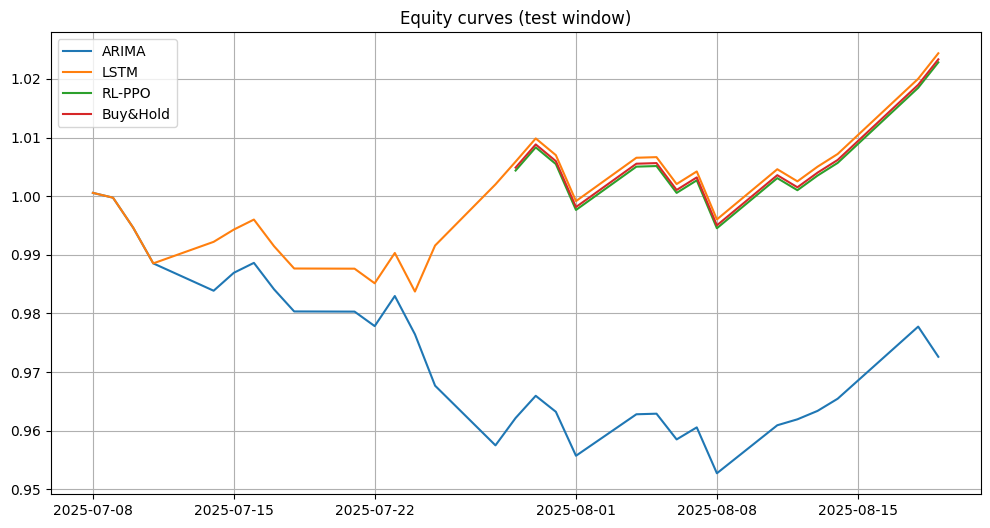

In [6]:
# Setup & Imports
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import yfinance as yf

# Statsmodels for ARIMA
from statsmodels.tsa.arima.model import ARIMA

# PyTorch for LSTM
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

# RL via Stable-Baselines3 (PPO) and Gymnasium env
try:
    import gymnasium as gym
except Exception:
    import gym as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import MlpExtractor
from stable_baselines3.common.vec_env import DummyVecEnv

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -------------- Config --------------
N_LOOKBACK = 60          # lookback days for features
TEST_WEEKS = 6           # evaluation horizon
TRANS_COST = 0.0005      # 5 bps per absolute change in position
THRESH = 0.0             # threshold for forecast sign trading
MIN_TRAIN_DAYS = 250

# Attempt to get latest Nifty100 tickers; fallback to curated list
CURATED = [
    "RELIANCE.NS","TCS.NS","HDFCBANK.NS","ICICIBANK.NS","INFY.NS","ITC.NS","HINDUNILVR.NS","BHARTIARTL.NS","SBIN.NS","BAJFINANCE.NS",
    "KOTAKBANK.NS","LT.NS","HCLTECH.NS","AXISBANK.NS","MARUTI.NS","ASIANPAINT.NS","SUNPHARMA.NS","TITAN.NS","ULTRACEMCO.NS","WIPRO.NS"
]

end = pd.Timestamp.today(tz="UTC").normalize()
start = end - pd.Timedelta(weeks=TEST_WEEKS + 60)  # include train history

# -------------- Data --------------
prices = yf.download(CURATED, start=start, end=end, auto_adjust=True, progress=False)
if isinstance(prices.columns, pd.MultiIndex):
    close = prices["Close"].copy()
else:   
    close = prices.copy()

close = close.dropna(axis=1, how='all').dropna()  # ensure aligned dates
rets = close.pct_change().dropna()

# Equal-weight portfolio return series
ew_ret = rets.mean(axis=1)

# Train/Test split: last 6 weeks as test
split_idx = -int(TEST_WEEKS*5) if len(rets) > TEST_WEEKS*5 else int(0.8*len(rets))
train_r, test_r = ew_ret[:split_idx], ew_ret[split_idx:]
train_p, test_p = close[:split_idx], close[split_idx:]

assert len(train_r) > MIN_TRAIN_DAYS, "Not enough training data; expand window."

# -------------- Utility: Metrics & Backtest --------------
def compute_metrics(returns: pd.Series, freq=252):
    if len(returns) == 0:
        return {"cagr": np.nan, "vol": np.nan, "sharpe": np.nan, "mdd": np.nan, "calmar": np.nan}
    c = (1+returns).cumprod()
    vol = returns.std() * np.sqrt(freq)
    cagr = c.iloc[-1]**(freq/len(returns)) - 1 if len(returns) > 0 else np.nan
    sharpe = returns.mean()/returns.std()*np.sqrt(freq) if returns.std()>0 else np.nan
    peak = c.cummax()
    dd = (c/peak - 1)
    mdd = dd.min()
    calmar = cagr/abs(mdd) if mdd < 0 else np.nan
    return {"cagr": cagr, "vol": vol, "sharpe": sharpe, "mdd": mdd, "calmar": calmar}

@dataclass
class BTResult:
    returns: pd.Series
    equity: pd.Series
    metrics: dict

def backtest_sign_forecast(forecast: pd.Series, realized: pd.Series, cost=TRANS_COST):
    # Position: sign of forecast (clip to -1..+1)
    pos = np.sign(forecast).replace(0, 0)
    pos = pos.reindex(realized.index).fillna(method='ffill').fillna(0)
    dpos = pos.diff().abs().fillna(0)
    ret = pos * realized - cost * dpos
    eq = (1+ret).cumprod()
    return BTResult(returns=ret, equity=eq, metrics=compute_metrics(ret))

# -------------- ARIMA Benchmark --------------
arima_orders = (1,0,1)
try:
    arima_forecasts = []
    hist = train_r.copy()
    for t in test_r.index:
        model = ARIMA(hist, order=arima_orders).fit()
        fc_series = model.forecast(steps=1)
        fc = float(fc_series.iloc[0])  # Use .iloc[0] for positional indexing
        arima_forecasts.append((t, fc))
        hist = pd.concat([hist, pd.Series([test_r.loc[t]], index=[t])])
    arima_fc_series = pd.Series(dict(arima_forecasts))
    arima_bt = backtest_sign_forecast(arima_fc_series, test_r)
except Exception as e:
    arima_fc_series, arima_bt = pd.Series(index=test_r.index, dtype=float), None
    print(f"ARIMA failed: {type(e).__name__}: {e}")

# -------------- LSTM Benchmark --------------
class LSTMReg(nn.Module):
    def __init__(self, input_dim=1, hidden=32, layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:,-1,:])

def make_sequences(series: pd.Series, lookback=N_LOOKBACK):
    x, y, idx = [], [], []
    vals = series.values.reshape(-1,1)
    for i in range(lookback, len(vals)):
        x.append(vals[i-lookback:i])
        y.append(vals[i])
        idx.append(series.index[i])
    x = np.array(x, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return x, y, idx

scaler = StandardScaler()
train_y = train_r.values.reshape(-1,1)
train_y_s = scaler.fit_transform(train_y).flatten()
train_r_s = pd.Series(train_y_s, index=train_r.index)

X_train, y_train, idx_train = make_sequences(train_r_s)
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train.reshape(-1,1))

lstm = LSTMReg()
crit = nn.MSELoss()
opt = torch.optim.Adam(lstm.parameters(), lr=1e-3)

EPOCHS = 30
BATCH = 64
for epoch in range(EPOCHS):
    perm = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH):
        idx_b = perm[i:i+BATCH]
        xb, yb = X_train_t[idx_b], y_train_t[idx_b]
        opt.zero_grad()
        pred = lstm(xb)
        loss = crit(pred, yb)
        loss.backward()
        opt.step()

# Roll forecasts through test
lstm_fc = []
roll_hist = pd.concat([train_r, test_r.iloc[:N_LOOKBACK]]) if len(test_r) > N_LOOKBACK else pd.concat([train_r])
for t in test_r.index:
    window = pd.concat([roll_hist, test_r.loc[:t]]).iloc[-N_LOOKBACK:]
    w_s = scaler.transform(window.values.reshape(-1,1)).reshape(1,N_LOOKBACK,1).astype(np.float32)
    with torch.no_grad():
        pred_s = lstm(torch.tensor(w_s))
    pred = scaler.inverse_transform(pred_s.numpy())
    lstm_fc.append((t, float(pred.squeeze())))

lstm_fc_series = pd.Series({t:v for t,v in lstm_fc})
lstm_bt = backtest_sign_forecast(lstm_fc_series, test_r)

# -------------- RL Environment & PPO --------------
class EWEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, returns_series: pd.Series, cost=TRANS_COST, lookback=N_LOOKBACK):
        super().__init__()
        # Ensure we have enough data for the lookback period
        if len(returns_series) <= lookback:
            raise ValueError(f"Not enough data: needed {lookback}, got {len(returns_series)}")
            
        # Convert Series to array and store both for efficient access
        self.r = returns_series
        self.r_values = returns_series.values
        self.r_index = returns_series.index
        self.cost = cost
        self.lookback = lookback  # Use the exact lookback value for observation space
        self.obs_idx = self.lookback  # Start after lookback window
        self.pos = 0.0
        # Observation: last N returns
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback,), dtype=np.float32)
        # Action: continuous position in [-1,1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
    def _get_obs(self):
        # Safe indexing with bounds check
        if self.obs_idx < self.lookback or self.obs_idx >= len(self.r_values):
            # Return zero observations with correct shape
            return np.zeros(self.lookback, dtype=np.float32)
        
        # Get observation window
        obs = self.r_values[self.obs_idx-self.lookback:self.obs_idx]
        
        # Check if observation has correct length, pad if needed
        if len(obs) < self.lookback:
            # Pad with zeros to match expected dimension
            padding = np.zeros(self.lookback - len(obs), dtype=np.float32)
            obs = np.concatenate([padding, obs])
        
        return obs.astype(np.float32)
        
    def reset(self, seed=None, options=None):
        # Handle compatibility with both older and newer gym/gymnasium
        if hasattr(super(), "reset") and callable(getattr(super(), "reset")):
            super().reset(seed=seed)
        # Reset state
        self.obs_idx = self.lookback
        self.pos = 0.0
        obs = self._get_obs()
        if options is None:
            options = {}
        return obs, {}
    
    def step(self, action):
        # Ensure action is properly formatted and clipped
        action_value = action[0] if hasattr(action, "__getitem__") else action
        action_clipped = float(np.clip(action_value, -1.0, 1.0))
        
        # Store previous position
        prev_pos = self.pos
        self.pos = action_clipped
        
        # Handle out-of-bounds
        if self.obs_idx >= len(self.r_values):
            return self._get_obs(), 0.0, True, False, {}
        
        # Calculate return and reward
        r_t = float(self.r_values[self.obs_idx])
        reward = self.pos * r_t - self.cost * abs(self.pos - prev_pos)
        
        # Update index and check termination
        self.obs_idx += 1
        terminated = self.obs_idx >= len(self.r_values)
        
        # Compatibility with both gym and gymnasium interfaces
        return self._get_obs(), reward, terminated, False, {}

# Split RL train/test on same index
rl_train = ew_ret[:split_idx]
rl_test = ew_ret[split_idx:]

# Make sure we have enough data in train and test sets
if len(rl_train) <= N_LOOKBACK * 2 or len(rl_test) <= N_LOOKBACK * 1.5:
    print(f"Warning: Not enough data for reliable RL. Train: {len(rl_train)}, Test: {len(rl_test)}, Lookback: {N_LOOKBACK}")
    # Adjust lookback if needed
    adjusted_lookback = min(N_LOOKBACK, len(rl_train) // 3, len(rl_test) // 2)
    if adjusted_lookback < N_LOOKBACK:
        print(f"Adjusting lookback from {N_LOOKBACK} to {adjusted_lookback} due to limited data")
    rl_lookback = adjusted_lookback
else:
    rl_lookback = N_LOOKBACK

# Create and train PPO model with proper error handling
try:
    # Train PPO on rl_train
    env = DummyVecEnv([lambda: EWEnv(rl_train, lookback=rl_lookback)])
    ppo = PPO("MlpPolicy", env, verbose=0, seed=42, 
              n_steps=256, batch_size=64,  # Smaller batch size
              ent_coef=0.01,  # Small entropy for exploration
              gae_lambda=0.95, gamma=0.99, 
              learning_rate=3e-4)
    ppo.learn(total_timesteps=50_000)

    # Evaluate on test with deterministic policy
    test_env = EWEnv(rl_test, lookback=rl_lookback)
    obs, _ = test_env.reset()
    rl_positions = []
    rl_returns = []
    rl_actions = []

    # Use the length of valid data points for evaluation
    valid_len = len(rl_test) - test_env.lookback
    idxs = rl_test.index[test_env.lookback:]

    for _ in range(valid_len):
        action, _ = ppo.predict(obs, deterministic=True)
        rl_actions.append(float(action[0]))
        obs, reward, done, trunc, _ = test_env.step(action)
        rl_returns.append(reward)
        rl_positions.append(test_env.pos)  # Track actual position
        if done:
            break

    # Create Series with proper indexes
    rl_returns = pd.Series(rl_returns, index=idxs[:len(rl_returns)])
    rl_equity = (1+rl_returns).cumprod()
    rl_metrics = compute_metrics(rl_returns)
    
    # Also create a Series for positions for analysis if needed
    rl_positions_series = pd.Series(rl_positions, index=idxs[:len(rl_positions)])

except Exception as e:
    print(f"RL-PPO training/evaluation failed: {type(e).__name__}: {e}")
    # Provide fallback metrics in case of failure
    rl_returns = pd.Series(index=rl_test.index[N_LOOKBACK:], dtype=float)
    rl_equity = pd.Series([1.0], index=[rl_test.index[N_LOOKBACK]])
    rl_metrics = {k: np.nan for k in ["cagr","vol","sharpe","mdd","calmar"]}

# -------------- Buy & Hold baseline --------------
bh_returns = rl_test.iloc[test_env.lookback:]
bh_equity = (1+bh_returns).cumprod()
bh_metrics = compute_metrics(bh_returns)

# -------------- Results: Summary & Plots --------------
results = {
    "ARIMA": arima_bt.metrics if arima_bt else {k: np.nan for k in ["cagr","vol","sharpe","mdd","calmar"]},
    "LSTM": lstm_bt.metrics,
    "RL-PPO": rl_metrics,
    "Buy&Hold": bh_metrics,
}

summary = pd.DataFrame(results).T
print("Performance summary (test window):")
print(summary)

plt.figure(figsize=(12,6))
if arima_bt:
    plt.plot(arima_bt.equity, label="ARIMA")
plt.plot(lstm_bt.equity, label="LSTM")
plt.plot(rl_equity, label="RL-PPO")
plt.plot(bh_equity, label="Buy&Hold")
plt.legend(); plt.title("Equity curves (test window)"); plt.grid(True)
plt.show()